In [ ]:
#Upload custom_logger.py in a folder named 'utils' and 'configs.json'

In [ ]:
pip install gradio langchain accelerate sentence_transformers pypdf tiktoken faiss-gpu bitsandbytes

In [ ]:
pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4


In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import TokenTextSplitter
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
import pickle
import os
from utils.custom_logger import logger

class DataLoadPDF:
    """
    A class for loading data from a PDF file.
    """

    def __init__(self, file_path):
        """
        Initialize the DataLoadPDF instance.

        Args:
            file_path (str): Path to the PDF file to load.
        """
        self.file_path = file_path

    def load_data(self):
        """
        Load data from the PDF file.

        Returns:
            list: List of pages from the PDF.
        """
        logger.info(f"Reading file {os.path.basename(self.file_path)} ... ")
        loader = PyPDFLoader(self.file_path)
        pages = loader.load()
        return pages

class DataSplitter:
    """
    A class for splitting data into chunks.
    """

    def __init__(self, chunk_size, chunk_overlap):
        """
        Initialize the DataSplitter instance.

        Args:
            chunk_size (int): Size of each chunk.
            chunk_overlap (int): Overlap between consecutive chunks.
        """
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

    def split_data(self, pages):
        """
        Split data into chunks.

        Args:
            pages (list): List of data pages.

        Returns:
            list: List of split documents.
        """
        logger.info(f"Document splitting with chunk_size {self.chunk_size} and chunk_overlap {self.chunk_overlap} ... ")
        text_splitter = TokenTextSplitter(
            chunk_size=self.chunk_size,
            chunk_overlap=self.chunk_overlap,
            length_function=len
        )
        docs = text_splitter.split_documents(pages)
        return docs

class EmbeddingManager:
    """
    A class for managing document embeddings.
    """

    def __init__(self, model_name):
        """
        Initialize the EmbeddingManager instance.

        Args:
            model_name (str): Name of the embedding model.
        """
        self.model_name = model_name
        logger.info(f"Loading embeddings Model {self.model_name} ... ")
        self.embeddings = HuggingFaceEmbeddings(model_name=self.model_name)

    def create_embeddings(self, docs):
        """
        Create embeddings for documents.

        Args:
            docs (list): List of documents.

        Returns:
            FAISS: Document embeddings.
        """
        logger.info(f"Creating document embeddings for {len(docs)} split ... ")
        self.doc_embedding = FAISS.from_documents(docs, self.embeddings)
        return self.doc_embedding

    def save_embedding(self, file_name):
        """
        Save document embeddings to a file.

        Args:
            file_name (str): Name of the file to save the embeddings.
        """
        emedding_dir = "embeddings_data"
        if not os.path.exists(emedding_dir):
            os.mkdir(emedding_dir)
        file_name = os.path.basename(file_name)
        logger.info(f"Saving document embeddings: {'embeddings_data/'+file_name} ... ")
        with open("embeddings_data/"+file_name+".pkl", "wb") as f:
            pickle.dump(self.doc_embedding, f)

    def load_embedding(self, file_name):
        """
        Load document embeddings from a file.

        Args:
            file_name (str): Name of the file to load the embeddings.

        Returns:
            FAISS: Loaded document embeddings.
        """
        file_name = os.path.basename(file_name)
        logger.info(f"Loading document embeddings locally: {'embeddings_data/'+file_name} ... ")
        with open("embeddings_data/"+file_name+".pkl", "rb") as f:
            self.doc_embedding = pickle.load(f)
        return self.doc_embedding

    def check_embedding_available(self, file_name):
        """
        Check if document embeddings are available in a file.

        Args:
            file_name (str): Name of the file to check.

        Returns:
            bool: True if document embeddings are available, False otherwise.
        """
        file_name = os.path.basename(file_name)
        doc_check = os.path.isfile("embeddings_data/"+file_name+".pkl")
        logger.info(f"Is document embedding found: {doc_check}")
        return doc_check

class DocumentProcessor:
    """
    A class for processing documents and managing embeddings.
    """

    def __init__(self, model_name, chunk_size, chunk_overlap):
        """
        Initialize the DocumentProcessor instance.

        Args:
            model_name (str): Name of the embedding model.
            chunk_size (int): Size of each chunk.
            chunk_overlap (int): Overlap between consecutive chunks.
        """
        logger.info(f"Initializing document processor parameters - embedding model_name: {model_name}, chunk_size: {chunk_size}, chunk_overlap: {chunk_overlap} ... ")
        self.model_name = model_name
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.embedding_manager = EmbeddingManager(model_name)

    def process_document(self, file_path):
        """
        Process a document and manage embeddings.

        Args:
            file_path (str): Path to the document file.

        Returns:
            FAISS: Document embeddings.
        """
        if self.embedding_manager.check_embedding_available(file_path):
            return self.embedding_manager.load_embedding(file_path)
        else:
            data_loader = DataLoadPDF(file_path)
            pages = data_loader.load_data()

            data_splitter = DataSplitter(self.chunk_size, self.chunk_overlap)
            docs = data_splitter.split_data(pages)

            doc_embedding = self.embedding_manager.create_embeddings(docs)
            self.embedding_manager.save_embedding(file_path)
            return doc_embedding


In [ ]:
from langchain import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
import torch
from utils.custom_logger import logger

class ModelLoader:
    """
    A class responsible for loading the language model.
    """

    def __init__(self, model_id, max_length, temperature,load_int8):
        """
        Initialize the ModelLoader instance.

        Args:
            model_id (str): Identifier of the pretrained model.
            max_length (int): Maximum length of generated text.
            temperature (float): Temperature parameter for text generation.
        """
        self.model_id = model_id
        self.max_length = max_length
        self.temperature = temperature
        self.load_int8 = load_int8

    def load_model(self):
        """
        Load the language model using the specified model_id, max_length, and temperature.

        Returns:
            HuggingFacePipeline: Loaded language model.
        """
        logger.info(f"Loading LLM model {self.model_id} with max_length {self.max_length} and temperature {self.temperature}...\n")
        tokenizer = AutoTokenizer.from_pretrained(self.model_id)
        if self.load_int8:
            model = AutoModelForCausalLM.from_pretrained(self.model_id, load_in_8bit=True, device_map="auto")
        else:
            model = AutoModelForCausalLM.from_pretrained(self.model_id, torch_dtype=torch.bfloat16, device_map="auto")

        logger.info("Model is loaded successfully\n")
        pipe = pipeline(
            "text-generation", model=model, tokenizer=tokenizer, max_length=self.max_length, temperature=self.temperature
        )
        llm = HuggingFacePipeline(pipeline=pipe)
        return llm

class QASystem:
    """
    A class representing a Question Answering (QA) system.
    """

    def __init__(self, llm):
        """
        Initialize the QASystem instance.

        Args:
            llm (HuggingFacePipeline): Loaded language model for text generation.
        """
        self.llm = llm

        self.prompt_template = """Use the following pieces of context to answer the question at the end.
        If you don't know the answer, just say that you don't know, don't try to make up an answer.

        {context}

        Question: {question}
        Answer :"""
        PROMPT = PromptTemplate(
            template=self.prompt_template, input_variables=["context", "question"]
        )
        self.chain_type_kwargs = {
            "prompt": PROMPT,
        }

    def setup_retrieval_qa(self, doc_embedding):
        """
        Set up the retrieval-based QA system.

        Args:
            doc_embedding: Document embedding for retrieval.

        Returns:
            RetrievalQA: Configured retrieval-based QA system.
        """
        logger.info("Setting up retrieval QA system...\n")
        qa = RetrievalQA.from_chain_type(
            llm=self.llm,
            chain_type="stuff",  # You might need to replace this with the appropriate chain type.
            retriever=doc_embedding.as_retriever(),
            chain_type_kwargs=self.chain_type_kwargs,
        )

        return qa


## Generate your HF TOKEN by setting up an account on HuggingFace.

In [ ]:
from huggingface_hub import login

# Replace 'YOUR_HF_TOKEN' with the token you generated
login(token='YOUR HF TOKEN')

In [ ]:
import gradio as gr
import json
import re
from utils.custom_logger import logger

with open('config.json', 'r') as config_file:
    config = json.load(config_file)

logger.info(f"Loaded config file: {config}")

# Loading embedding model
document_processor = DocumentProcessor(model_name=config["embedding_model_name"], chunk_size=config["chunk_size"], chunk_overlap=config["chunk_overlap"])

# Load model globally
model_loder = ModelLoader(config["model_id"], config["max_length"], config["temperature"],config['load_int8'])
llm = model_loder.load_model()

qa_system = QASystem(llm)

# Initialize global variable for doc_embedding
doc_embedding = None
pdf_file_name = None
qa = None
def chatbot(pdf_file,query):
    global doc_embedding
    global pdf_file_name
    global qa
    if pdf_file_name is None or pdf_file_name!= pdf_file.name or doc_embedding is None:
        logger.info("New PDF Found Resetting doc_embedding")
        doc_embedding = None
        pdf_file_name = pdf_file.name
    if doc_embedding is None:
        logger.info("Starting for new doc_embedding")
        doc_embedding = document_processor.process_document(pdf_file.name)
        qa = qa_system.setup_retrieval_qa(doc_embedding)
    result = qa({"query": query})
    return re.sub(r'\n+', '\n', result['result'])

with gr.Blocks(theme=gr.themes.Default(primary_hue="red", secondary_hue="pink")) as demo:
    gr.Markdown("# Ask your Question to PDF Document")
    with gr.Row():
        with gr.Column(scale=4):
            pdf_file = gr.File(label="Upload your PDF")
    output = gr.Textbox(label="output",lines=3)
    query = gr.Textbox(label="query")
    btn = gr.Button("Submit")
    btn.click(fn=chatbot, inputs=[pdf_file,query], outputs=[output])
gr.close_all()
demo.launch(share=True)


2024-11-06 16:43:34,652 - INFO - <ipython-input-10-83e52df40f01>:9 - Loaded config file: {'embedding_model_name': 'thenlper/gte-base', 'model_id': 'meta-llama/Llama-2-7b-chat-hf', 'chunk_size': 500, 'chunk_overlap': 50, 'max_length': 2000, 'temperature': 0.05, 'load_int8': True}
INFO:custom_logger:Loaded config file: {'embedding_model_name': 'thenlper/gte-base', 'model_id': 'meta-llama/Llama-2-7b-chat-hf', 'chunk_size': 500, 'chunk_overlap': 50, 'max_length': 2000, 'temperature': 0.05, 'load_int8': True}
2024-11-06 16:43:34,658 - INFO - <ipython-input-6-5fd32e2d55a4>:160 - Initializing document processor parameters - embedding model_name: thenlper/gte-base, chunk_size: 500, chunk_overlap: 50 ... 
INFO:custom_logger:Initializing document processor parameters - embedding model_name: thenlper/gte-base, chunk_size: 500, chunk_overlap: 50 ... 
2024-11-06 16:43:34,661 - INFO - <ipython-input-6-5fd32e2d55a4>:83 - Loading embeddings Model thenlper/gte-base ... 
INFO:custom_logger:Loading embed

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-11-06 16:43:48,947 - INFO - <ipython-input-7-3bdf709143f4>:34 - Loading LLM model meta-llama/Llama-2-7b-chat-hf with max_length 2000 and temperature 0.05...

INFO:custom_logger:Loading LLM model meta-llama/Llama-2-7b-chat-hf with max_length 2000 and temperature 0.05...



tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

2024-11-06 16:46:23,840 - INFO - <ipython-input-7-3bdf709143f4>:41 - Model is loaded successfully

INFO:custom_logger:Model is loaded successfully

<ipython-input-7-3bdf709143f4>:45: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8be4477ec873ad64fc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Once you have run everything, you will find the app running with the following UI:

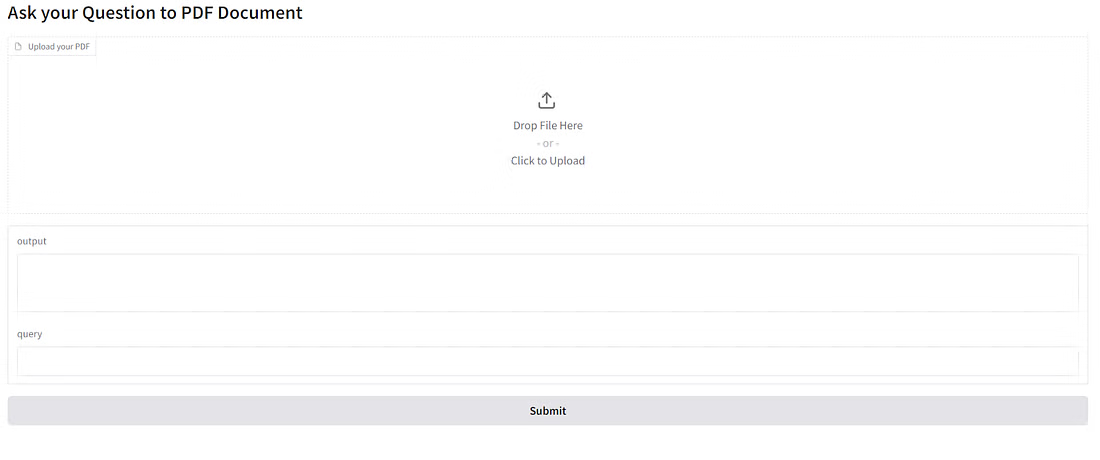

To test it, you can upload ProjectPro’s Generative AI Interview Questions and Answers PDF’ and ask the question "What is Generative AI?”. The application will return the appropriate response, as highlighted in the image below.

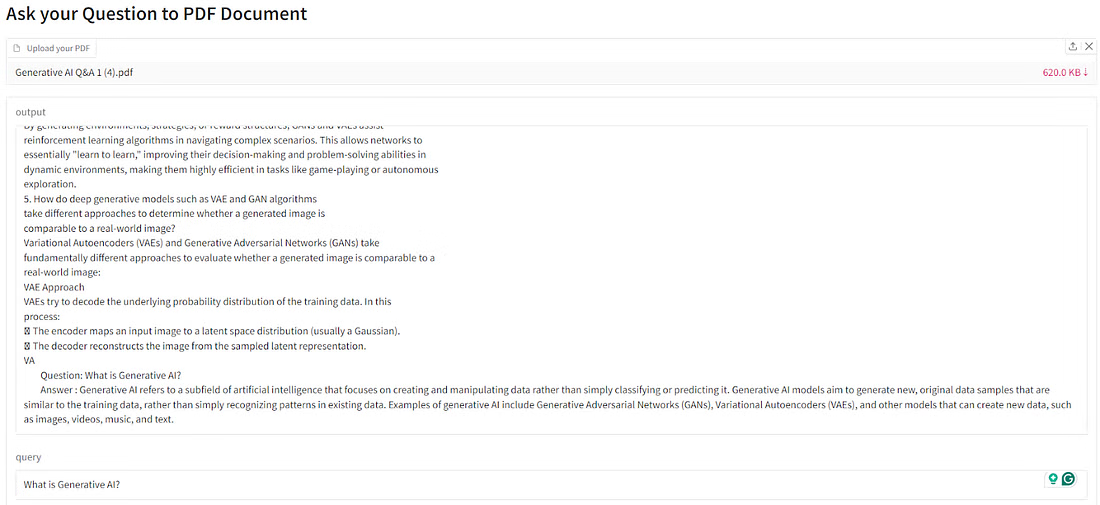
